In [1]:
import random
import numpy as np
import tensorflow as tf

# Fijar semillas para reproducibilidad
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Cargar y preparar los datos
df = pd.read_csv("df_final.csv")
df["date_y"] = pd.to_datetime(df["date_y"])

# Identificar columnas
x_start_col = "mean_vote_x"
x_columns = df.columns[df.columns.get_loc(x_start_col):]
y_column = "vote_y"
id_column = "employeeId"
date_column = "date_y"
lookback = 4
MAX_DELTA = 180  # máximo permitido entre pasos (en días)

# Calcular observaciones por empleado
obs_por_empleado = df[id_column].value_counts()
empleados_validos = obs_por_empleado[obs_por_empleado >= lookback].index
df_filtrado = df[df[id_column].isin(empleados_validos)]
df_filtrado = df_filtrado.sort_values(by=[id_column, date_column])

# Calcular delta y normalizar
df_filtrado["delta_days"] = df_filtrado.groupby(id_column)[date_column].diff().dt.days.fillna(0)
while True:
    # Filtrar
    df_filtrado = df_filtrado[df_filtrado["delta_days"] <= MAX_DELTA].copy()

    # Reordenar y recalcular
    df_filtrado = df_filtrado.sort_values(by=[id_column, date_column])
    df_filtrado["delta_days"] = df_filtrado.groupby(id_column)[date_column].diff().dt.days.fillna(0)

    # Condición de parada
    if (df_filtrado["delta_days"] <= MAX_DELTA).all():
        break

scaler = MinMaxScaler()
scaler_y = MinMaxScaler()
# Identificar columnas que terminan con "_has_value"
has_value_columns = [col for col in df_filtrado.columns if col.endswith('_has_value')]

# Identificar columnas previas a las "_has_value"
previous_columns = [
    col for col in df_filtrado.columns if col + "_has_value" in has_value_columns
]

# Incluir 'mean_vote_x' en las columnas a normalizar
columns_to_normalize = previous_columns + ['mean_vote_x'] + ['delta_days']

# Normalizar columnas seleccionadas
df_filtrado[columns_to_normalize] = scaler.fit_transform(df_filtrado[columns_to_normalize])
df_filtrado['vote_y'] = scaler_y.fit_transform(df_filtrado[['vote_y']])

# Añadir delta a las columnas X
x_columns = list(x_columns)
x_columns.append("delta_days")

# Inicializar secuencias
X_seqs = []
y_seqs = []
id_seqs = []

# Generar ventanas deslizantes (lookback = 4)
for emp_id, group in df_filtrado.groupby(id_column):
    group = group.sort_values(by=date_column)
    X_vals = group[x_columns].values
    y_vals = group[y_column].values

    for i in range(len(group) - lookback + 1):
        X_seq = X_vals[i:i+lookback]
        y_target = y_vals[i + lookback - 1]
        X_seqs.append(X_seq)
        y_seqs.append(y_target)
        id_seqs.append(emp_id)

# Convertir a arrays
X_array = np.array(X_seqs)
y_array = np.array(y_seqs)
id_array = np.array(id_seqs)

# Mostrar resumen
print("Total de secuencias válidas generadas:", len(X_array))
print("Forma de X:", X_array.shape)
print("Forma de Y:", y_array.shape)


Total de secuencias válidas generadas: 31527
Forma de X: (31527, 4, 110)
Forma de Y: (31527,)


In [7]:
X_array[1]

array([[0.98      , 1.        , 1.        , 1.        , 1.        ,
        0.6       , 1.        , 1.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.7       , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.9       ,
        1.        , 1.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 1.        , 0.        ,
        0.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 0.9       , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.9       ,
        1.        , 1.        , 1.        , 0.        , 0.        ,
        0.7       , 1.        , 0.        , 0.        , 1.        ,
        1.        , 0.9       , 1.        , 0.        , 0.        ,
        0.8       , 1.        , 0.        , 0.        , 0.5       ,
        1.        , 0.8       , 1.        , 0.8 

In [4]:
y_array

array([1.        , 0.88888889, 1.        , ..., 1.        , 1.        ,
       0.77777778])

In [11]:
from sklearn.model_selection import train_test_split

# Paso 1: obtener IDs únicos de empleados
empleados = np.unique(id_array)

# Paso 2: dividir empleados entre train (70%) y temp (30%)
empleados_train, empleados_temp = train_test_split(empleados, test_size=0.3)

# Paso 3: dividir temp entre validación (15%) y test (15%)
empleados_val, empleados_test = train_test_split(empleados_temp, test_size=0.5)

# Paso 4: crear máscaras por conjunto
mask_train = np.isin(id_array, empleados_train)
mask_val = np.isin(id_array, empleados_val)
mask_test = np.isin(id_array, empleados_test)

# Paso 5: aplicar máscaras para obtener particiones finales
X_train, y_train = X_array[mask_train], y_array[mask_train]
X_val, y_val = X_array[mask_val], y_array[mask_val]
X_test, y_test = X_array[mask_test], y_array[mask_test]

# Verifica tamaños
print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)

Train: (6481, 4, 110)
Validation: (1401, 4, 110)
Test: (1312, 4, 110)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath="best_lstm_model.keras",     # 📁 Ruta para guardar el modelo
    monitor="val_loss",                  # 🎯 Métrica a vigilar
    save_best_only=True,                # 💾 Solo guarda si mejora
    save_weights_only=False,            # 🧠 Guarda todo el modelo, no solo pesos
    verbose=1
)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import load_model

# Definir el modelo LSTM
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # salida de regresión
])

# Compilar el modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Entrenar el modelo
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint],
    verbose=1
)

Epoch 1/50
343/345 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1399 - mae: 0.2786
Epoch 1: val_loss improved from inf to 0.02746, saving model to best_lstm_model.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1393 - mae: 0.2779 - val_loss: 0.0275 - val_mae: 0.1304
Epoch 2/50
332/345 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0379 - mae: 0.1519
Epoch 2: val_loss improved from 0.02746 to 0.02288, saving model to best_lstm_model.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0378 - mae: 0.1516 - val_loss: 0.0229 - val_mae: 0.1139
Epoch 3/50
344/345 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0303 - mae: 0.1332
Epoch 3: val_loss improved from 0.02288 to 0.02060, saving model to best_lstm_model.keras
345/345 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0303 - mae: 0.1332 - val_loss: 0.0206 - val_mae: 0.1026
Epoch 4/50
338/345 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0279 - mae: 0.1262
Epoch 4: val_loss improved from 0.02060 to 0.02001, saving model to best_lstm_model.keras

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import load_model

# 1. Cargar modelo
best_loaded_model_lstm_base = load_model("best_lstm_model.keras")

# 2. Predecir con datos normalizados
y_pred_scaled = best_loaded_model_lstm_base.predict(X_test).flatten()

# 3. Desnormalizar
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 4. Calcular métricas en escala original
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# 5. Mostrar resultados
print("🎯 Resultados en escala original:")
print(f"📊 MSE (Error cuadrático medio): {mse:.4f}")
print(f"📏 MAE (Error absoluto medio):  {mae:.4f}")
print(f"📈 R² (Coeficiente de determinación): {r2:.4f}")


151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
🎯 Resultados en escala original:
📊 MSE (Error cuadrático medio): 1.4121
📏 MAE (Error absoluto medio):  0.8239
📈 R² (Coeficiente de determinación): 0.6533


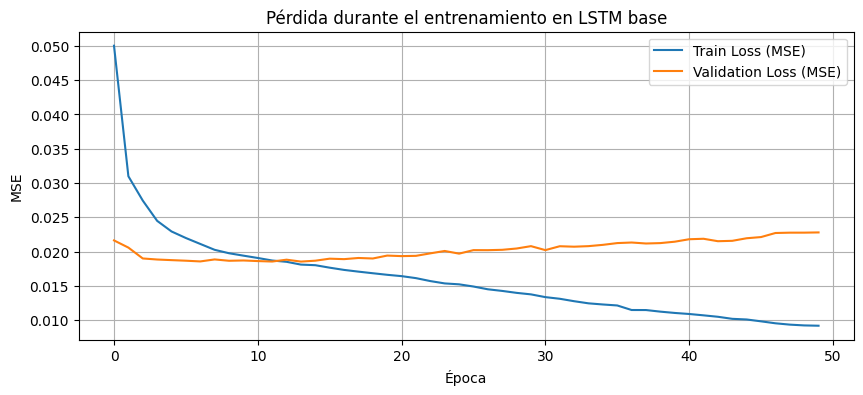

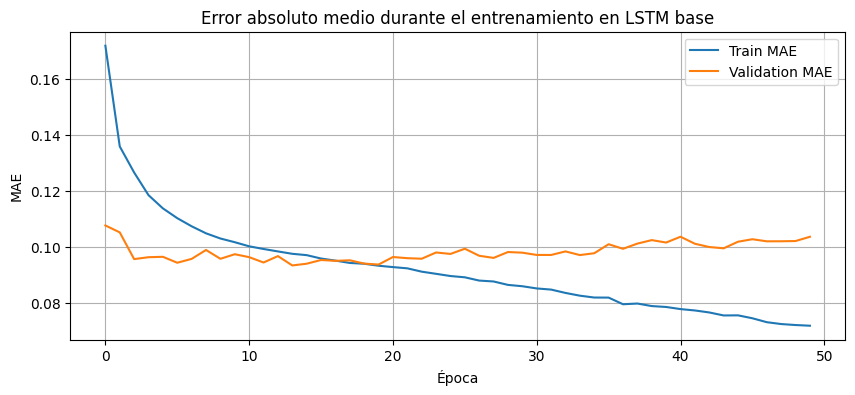

In [ ]:
import matplotlib.pyplot as plt

# Visualizar pérdida (MSE)
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.title('Pérdida durante el entrenamiento en LSTM base')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

# Visualizar MAE
plt.figure(figsize=(10, 4))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Error absoluto medio durante el entrenamiento en LSTM base')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.show()


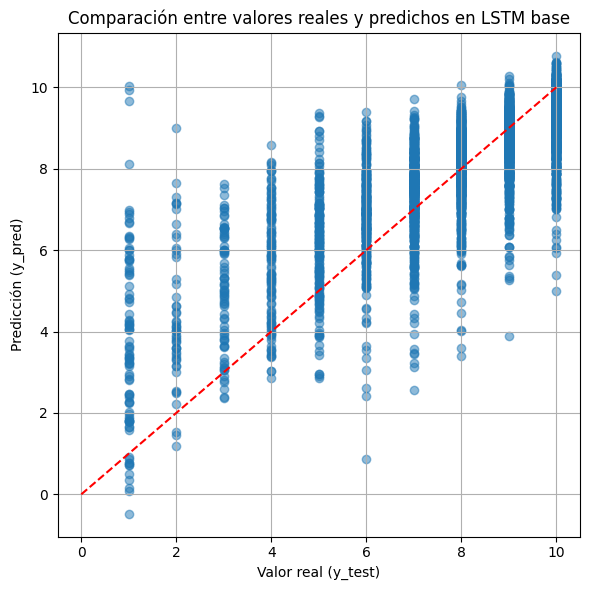

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot: predicción vs. valor real
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([0, 10], [0, 10], 'r--')  # Línea de referencia: y = x
plt.xlabel("Valor real (y_test)")
plt.ylabel("Predicción (y_pred)")
plt.title("Comparación entre valores reales y predichos en LSTM base")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_model(hp):
    model = Sequential()

    # Número de capas LSTM (1 o 2)
    for i in range(hp.Int("num_lstm_layers", 1, 2)):
        return_seq = (i < hp.get("num_lstm_layers") - 1)
        model.add(
            LSTM(
                units=hp.Int(f"units_lstm_{i}", min_value=32, max_value=128, step=32),
                return_sequences=return_seq,
                input_shape=(X_train.shape[1], X_train.shape[2]) if i == 0 else None
            )
        )
        model.add(Dropout(hp.Float(f"dropout_{i}", 0.2, 0.5, step=0.1)))

    # Capa densa intermedia
    model.add(Dense(units=hp.Int("dense_units", 16, 64, step=16), activation="relu"))

    # Capa dropout intermedia
    model.add(Dropout(hp.Float(f"dropout_dense", 0.2, 0.5, step=0.1)))

    # Capa de salida
    model.add(Dense(1))

    # Compilar
    model.compile(
        optimizer="adam",
        loss="mse",
        metrics=["mae"]
    )

    return model


In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=50,
    executions_per_trial=1,
    directory="tuner_logs",
    project_name="lstm_enps"
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Ejecutar búsqueda
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Mostrar mejor modelo
best_hps = tuner.get_best_hyperparameters(1)[0]

print("Mejores hiperparámetros encontrados:")
print(best_hps.values)


Trial 50 Complete [00h 01m 11s]
val_loss: 0.018623430281877518

Best val_loss So Far: 0.018463416025042534
Total elapsed time: 01h 09m 30s
Mejores hiperparámetros encontrados:
{'num_lstm_layers': 1, 'units_lstm_0': 64, 'dropout_0': 0.30000000000000004, 'dense_units': 64, 'dropout_1': 0.30000000000000004, 'units_lstm_1': 96, 'dropout_2': 0.2}


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath="best_hyperlstm_model.keras",     # 📁 Ruta para guardar el modelo
    monitor="val_loss",                  # 🎯 Métrica a vigilar
    save_best_only=True,                # 💾 Solo guarda si mejora
    save_weights_only=False,            # 🧠 Guarda todo el modelo, no solo pesos
    verbose=1
)

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint],
    verbose=1
)

In [ ]:
# 1. Cargar modelo
best_loaded_model_lstm_hyper = load_model("best_hyperlstm_model.keras")

# 2. Predecir con datos normalizados
y_pred_scaled = best_loaded_model_lstm_hyper.predict(X_test).flatten()

# 3. Desnormalizar
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 4. Calcular métricas en escala original
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# 5. Mostrar resultados
print("🎯 Resultados en escala original:")
print(f"📊 MSE (Error cuadrático medio): {mse:.4f}")
print(f"📏 MAE (Error absoluto medio):  {mae:.4f}")
print(f"📈 R² (Coeficiente de determinación): {r2:.4f}")


151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
🎯 Resultados en escala original:
📊 MSE (Error cuadrático medio): 1.4081
📏 MAE (Error absoluto medio):  0.8180
📈 R² (Coeficiente de determinación): 0.6543


In [ ]:
# 🔵 Graficar la pérdida (MSE)
plt.figure(figsize=(10, 4))
plt.plot(history.history["loss"], label="Train Loss (MSE)")
plt.plot(history.history["val_loss"], label="Val Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Pérdida durante el entrenamiento en LSTM hypertuned")
plt.legend()
plt.grid(True)
plt.show()

# 🟠 Graficar el MAE
plt.figure(figsize=(10, 4))
plt.plot(history.history["mae"], label="Train MAE")
plt.plot(history.history["val_mae"], label="Val MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Error absoluto medio durante el entrenamiento en LSTM hypertuned")
plt.legend()
plt.grid(True)
plt.show()

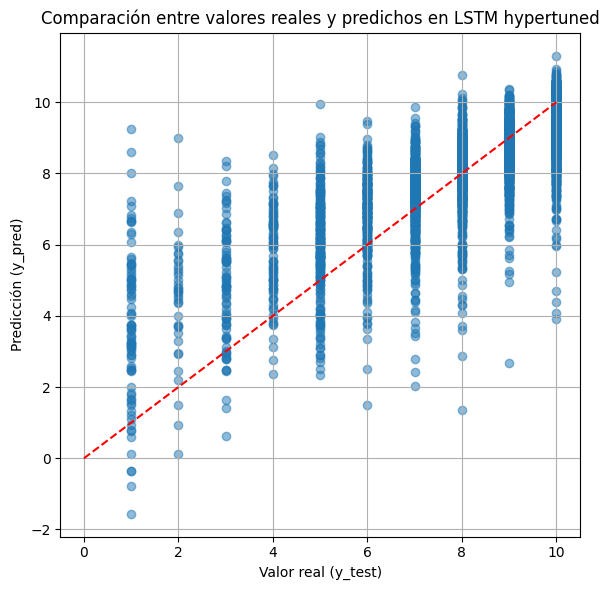

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot: predicción vs. valor real
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([0, 10], [0, 10], 'r--')  # Línea de referencia: y = x
plt.xlabel("Valor real (y_test)")
plt.ylabel("Predicción (y_pred)")
plt.title("Comparación entre valores reales y predichos en LSTM hypertuned")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath="best_mlp_model.keras",     # 📁 Ruta para guardar el modelo
    monitor="val_loss",                  # 🎯 Métrica a vigilar
    save_best_only=True,                # 💾 Solo guarda si mejora
    save_weights_only=False,            # 🧠 Guarda todo el modelo, no solo pesos
    verbose=1
)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout

# Crear modelo MLP
mlp_model = Sequential()
mlp_model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
mlp_model.add(Flatten())
mlp_model.add(Dense(64, activation="relu"))
mlp_model.add(Dropout(0.3)),
mlp_model.add(Dense(32, activation="relu"))
mlp_model.add(Dropout(0.2)),
mlp_model.add(Dense(1))  # salida para regresión

# Compilar el modelo
mlp_model.compile(
    optimizer='adam',
    loss="mse",
    metrics=["mae"]
)

# Entrenar el modelo
history = mlp_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[checkpoint],
    verbose=1
)

In [ ]:
# 1. Cargar modelo
best_loaded_model_mlp = load_model("best_mlp_model.keras")

# 2. Predecir con datos normalizados
y_pred_scaled = best_loaded_model_mlp.predict(X_test).flatten()

# 3. Desnormalizar
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 4. Calcular métricas en escala original
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# 5. Mostrar resultados
print("🎯 Resultados en escala original:")
print(f"📊 MSE (Error cuadrático medio): {mse:.4f}")
print(f"📏 MAE (Error absoluto medio):  {mae:.4f}")
print(f"📈 R² (Coeficiente de determinación): {r2:.4f}")

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
🎯 Resultados en escala original:
📊 MSE (Error cuadrático medio): 1.5298
📏 MAE (Error absoluto medio):  0.9024
📈 R² (Coeficiente de determinación): 0.6244


In [ ]:
# 🔵 Graficar la pérdida (MSE)
plt.figure(figsize=(10, 4))
plt.plot(history.history["loss"], label="Train Loss (MSE)")
plt.plot(history.history["val_loss"], label="Val Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Pérdida durante el entrenamiento en MLP base")
plt.legend()
plt.grid(True)
plt.show()

# 🟠 Graficar el MAE
plt.figure(figsize=(10, 4))
plt.plot(history.history["mae"], label="Train MAE")
plt.plot(history.history["val_mae"], label="Val MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Error absoluto medio durante el entrenamiento en MLP base")
plt.legend()
plt.grid(True)
plt.show()

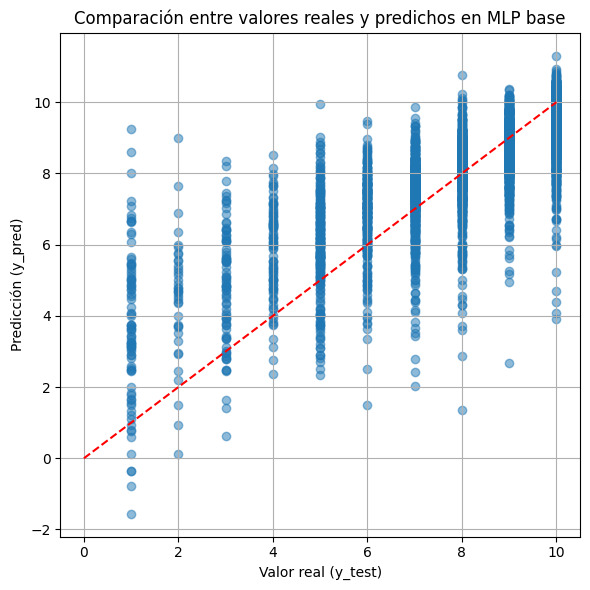

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot: predicción vs. valor real
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([0, 10], [0, 10], 'r--')  # Línea de referencia: y = x
plt.xlabel("Valor real (y_test)")
plt.ylabel("Predicción (y_pred)")
plt.title("Comparación entre valores reales y predichos en MLP base")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

def build_mlp_model_with_sequences(hp):
    model = Sequential()

    # 👉 Aplanar la entrada secuencial (timesteps, features) → (timesteps × features)
    model.add(Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))

    # Primera capa oculta
    model.add(Dense(
        units=hp.Int("units_1", min_value=32, max_value=128, step=32),
        activation="relu"
    ))
    model.add(Dropout(hp.Float("dropout_1", 0.1, 0.5, step=0.1)))

    # Segunda capa oculta opcional
    if hp.Boolean("add_second_layer"):
        model.add(Dense(
            units=hp.Int("units_2", min_value=16, max_value=64, step=16),
            activation="relu"
        ))
        model.add(Dropout(hp.Float("dropout_2", 0.1, 0.5, step=0.1)))

    # Capa de salida
    model.add(Dense(1))

    # Compilar
    model.compile(
        optimizer=Adam(),
        loss="mse",
        metrics=["mae"]
    )

    return model


In [ ]:
tuner_mlp = kt.RandomSearch(
    build_mlp_model_with_sequences,
    objective="val_loss",
    max_trials=50,
    executions_per_trial=1,
    directory="mlp_tuning",
    project_name="enps_mlp"
)

In [ ]:
tuner_mlp.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    verbose=1
)
# Mostrar mejor modelo
best_hps = tuner_mlp.get_best_hyperparameters(1)[0]

print("Mejores hiperparámetros encontrados:")
print(best_hps.values)

In [ ]:
checkpoint = ModelCheckpoint(
    filepath="best_hyper_mlp_model.keras",     # 📁 Ruta para guardar el modelo
    monitor="val_loss",                  # 🎯 Métrica a vigilar
    save_best_only=True,                # 💾 Solo guarda si mejora
    save_weights_only=False,            # 🧠 Guarda todo el modelo, no solo pesos
    verbose=1
)

In [ ]:
model_mlp = tuner_mlp.hypermodel.build(best_hps)
history = model_mlp.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint],
    verbose=1
)

In [ ]:
# 1. Cargar modelo
best_loaded_model_hyper_mlp = load_model("best_hyper_mlp_model.keras")

# 2. Predecir con datos normalizados
y_pred_scaled = best_loaded_model_hyper_mlp.predict(X_test).flatten()

# 3. Desnormalizar
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 4. Calcular métricas en escala original
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# 5. Mostrar resultados
print("🎯 Resultados en escala original:")
print(f"📊 MSE (Error cuadrático medio): {mse:.4f}")
print(f"📏 MAE (Error absoluto medio):  {mae:.4f}")
print(f"📈 R² (Coeficiente de determinación): {r2:.4f}")

151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
🎯 Resultados en escala original:
📊 MSE (Error cuadrático medio): 1.4819
📏 MAE (Error absoluto medio):  0.8486
📈 R² (Coeficiente de determinación): 0.6362


In [ ]:
# 🔵 Graficar la pérdida (MSE)
plt.figure(figsize=(10, 4))
plt.plot(history.history["loss"], label="Train Loss (MSE)")
plt.plot(history.history["val_loss"], label="Val Loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Pérdida durante el entrenamiento en MLP hypertuned")
plt.legend()
plt.grid(True)
plt.show()

# 🟠 Graficar el MAE
plt.figure(figsize=(10, 4))
plt.plot(history.history["mae"], label="Train MAE")
plt.plot(history.history["val_mae"], label="Val MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.title("Error absoluto medio durante el entrenamiento en MLP hypertuned")
plt.legend()
plt.grid(True)
plt.show()

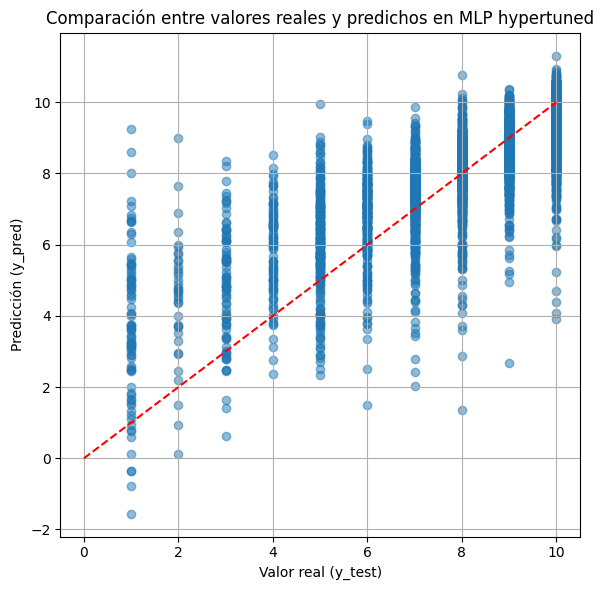

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot: predicción vs. valor real
plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([0, 10], [0, 10], 'r--')  # Línea de referencia: y = x
plt.xlabel("Valor real (y_test)")
plt.ylabel("Predicción (y_pred)")
plt.title("Comparación entre valores reales y predichos en MLP hypertuned")
plt.grid(True)
plt.tight_layout()
plt.show()
